<img src="./image/labai.png" width="200px">

# Text Generation with GRU

In this exercise your goal is to build text generation model with GRU model by complete all piece of code below, you can add or change code as we can


**Objective**:  
In this exercise, your goal is to build a text generation model using a Gated Recurrent Unit (GRU). You will complete all the provided code segments and are encouraged to add or modify code to improve the model. The key steps involve:

1. Preprocessing the text data.
2. Implementing the GRU-based neural network.
3. Training the model on the provided dataset.
4. Generating new text based on a seed sequence.

**Instructions**:
- Follow the code structure provided and complete the missing sections.
- Experiment with different hyperparameters to improve performance.
- You are free to adjust the code as needed to enhance results


In [ ]:
import re
import torch
import torchtext
import torch.nn as nn
from pathlib import Path
from typing import List,Dict

# import lightning as L
import torch.nn.functional as F
import torch.optim as optim
import unicodedata
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.vocab  import build_vocab_from_iterator
# from lightning.pytorch.loggers import TensorBoardLogger

# Attempt GPU; if not, stay on CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


## Create a Data Loader

#### Load Raw Data

In [2]:
text = Path('./data/tiny-shakespeare.txt').read_text()
print(f'Number of characters in text file: {len(text):,}')

Number of characters in text file: 1,115,394


In [3]:
print(text[0:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


#### Tokenization

In [4]:
class  WordTokenizer(nn.Module):
    def __init__(self, vocab: torchtext.vocab.Vocab|Dict[str,int])-> None:
        super().__init__()

        if isinstance(vocab, torchtext.vocab.Vocab):
            self.token2id=vocab.get_stoi()
            self.id2token={id:ch for ch,id in vocab.get_stoi().items()}
            self.vocab_size=len(self.token2id)

        elif isinstance(vocab, dict):
            self.token2id=vocab
            self.id2token={id:ch for ch,id in vocab.items()}
            self.vocab_size=len(self.token2id)

        else:
            raise TypeError("Please loads a vocabulary file into a dictionary \
                            Dict[str,int] or torchtext.vocab.Vocab")

    def encode(self, text:List[str]|str):
        if isinstance(text, str):
            text_list=self.tokenize(text)

        token_id=[]
        for token in text_list:
            token_id.append(self.token2id[token])
        return  torch.tensor(token_id,  dtype=torch.long)


    def decode(self, idx:torch.tensor):
        #idx: torch.Tensor containing integers
        token=[]
        for id in idx.tolist():
            token.append(self.id2token[id])
        return ' '.join(token)

    @staticmethod
    def tokenize(text: str) -> List[str]:

        # Normalize incoming text; can be multiple actions
        text= text.lower() ## Your code Here ##

        # split text into tokens
        tokens= re.split(r'\W+', text) ## Your code Here ##

        return tokens

    @staticmethod
    def _tokenizer_corpus(corpus:List[str]):
        for text in corpus:
            yield WordTokenizer.tokenize(text)

    @staticmethod
    def train_from_text(text: str) -> List[str]:
        """build vocab from one text corpus"""
        vocab=build_vocab_from_iterator(WordTokenizer._tokenizer_corpus(WordTokenizer.tokenize(text)),
                                        specials=["<unk>"]
                                       )
        vocab.set_default_index(vocab["<unk>"])

        return WordTokenizer(vocab)


In [5]:
# create tokenizer from text
tokenizer = WordTokenizer.train_from_text(text)

In [6]:
# show example of word-based tokens
print(tokenizer.tokenize(text[0:300]))

['first', 'citizen', 'before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', 'all', 'speak', 'speak', 'first', 'citizen', 'you', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish', 'all', 'resolved', 'resolved', 'first', 'citizen', 'first', 'you', 'know', 'caius', 'marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people', 'all', 'we', 'know', 't', 'we', 'know', 't', 'first', 'citizen', 'let', 'us']


In [7]:
# tokenization
encode_text=tokenizer.encode("Welcome to the deep learning course.")
encode_text

tensor([ 304,    4,    1,  553, 3000,  659, 6539])

In [8]:
decode_text=tokenizer.decode(encode_text)
decode_text

'welcome to the deep learning course '

#### Prepare Dataset

In [9]:
class ShakespeareDataset(Dataset):
    def __init__(self, encode_text, max_seq_length: int):
        self.encode_text     = encode_text
        self.max_seq_length  = max_seq_length

    def __len__(self):
        return len(self.encode_text)-self.max_seq_length

    def __getitem__(self, idx):
        assert idx < len(self.encode_text)-self.max_seq_length

        x_train= self.encode_text[idx:idx+self.max_seq_length]

        # Target is shifted by one character/token
        y_target= self.encode_text[idx+1:idx+1+self.max_seq_length]

        return x_train, y_target


In [ ]:
dataset = ShakespeareDataset(encode_text=tokenizer.encode(text),max_seq_length=100)
len(dataset[0])

2

In [11]:
tokenizer.decode(dataset[0][0])

'first citizen before we proceed any further hear me speak all speak speak first citizen you are all resolved rather to die than to famish all resolved resolved first citizen first you know caius marcius is chief enemy to the people all we know t we know t first citizen let us kill him and we ll have corn at our own price is t a verdict all no more talking on t let it be done away away second citizen one word good citizens first citizen we are accounted poor citizens the patricians good what authority surfeits on would'

In [12]:
tokenizer.decode(dataset[1][0])

'citizen before we proceed any further hear me speak all speak speak first citizen you are all resolved rather to die than to famish all resolved resolved first citizen first you know caius marcius is chief enemy to the people all we know t we know t first citizen let us kill him and we ll have corn at our own price is t a verdict all no more talking on t let it be done away away second citizen one word good citizens first citizen we are accounted poor citizens the patricians good what authority surfeits on would relieve'

In [13]:
# batch dataset
train_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [ ]:
for X_batch, y_batch in train_dataloader:
  print(X_batch, y_batch)
  break

In [ ]:
X_batch.shape

In [ ]:
y_batch.shape

## Build GRU model


In [47]:
class GRUTextGen(nn.Module):
    def __init__(self,
                 tokenizer: WordTokenizer,
                 embedding_dim, 
                 hidden_dim, 
                 num_layers, 
                 dropout):
        super(GRUTextGen, self).__init__()

        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self. num_layers= num_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)

        self.gru = nn.GRU(input_size=self.embedding_dim,
                          hidden_size=self.hidden_dim,
                          num_layers=self. num_layers,
                          dropout=self.dropout,
                          batch_first=True)

        self.fc = nn.Linear(in_features=hidden_dim, out_features=self.vocab_size)

    def forward(self, x: torch.tensor):
        assert x.ndim==2  # x tensor must be 2D dimensions with shape (B,S), B=batch, S=sequence length
        x = self.embedding(x)
        output, _ = self.gru(x)
        logits = self.fc(output)
        return logits
    
    def fit(self, epochs = 5, 
                  from_epoch = 0,
                  optimizer=optim.Adam,
                  lr=0.001,
                  loss_function = nn.CrossEntropyLoss()):
        
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(from_epoch, epochs+from_epoch):
          # Set model into "training mode"
          self.train()
          total_loss = 0

          count = 0
          for X_batch, y_batch in train_dataloader:
              X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
              optimizer.zero_grad()
              output = self(X_batch)
              loss = loss_function(output.view(-1, output.size(-1)), y_batch.view(-1))
              loss.backward()
              optimizer.step()
              total_loss += loss.item()

              count += 1
              if count % 100 == 0:
                print(f'Batch {count}/{len(train_dataloader)}, Loss: {total_loss / len(train_dataloader)}')
                model_name = f'rnn_epoch_{epoch+1}_batch_{count}.net'

                with open(model_name, 'wb') as f:
                    torch.save(self.state_dict(), f)

          print(f'Epoch {epoch + 1}/{epochs+from_epoch}, Loss: {total_loss / len(train_dataloader)}')

          path = f'rnn_epoch_{epoch+1}_completed.net'
          with open(path, 'wb') as f:
            torch.save(self.state_dict(), f)

          print("Sample output:")

          gen_output = self.predict(
              temperature=0.8,
              max_tokens=30,
              top_k=None,
              do_sample=False
          )
          print(gen_output)

          print('-'*72)
    
    @torch.no_grad()
    def predict(self, 
                input_text: str = "To be or not to be", 
                max_tokens: int = 15, 
                temperature: float = 1, 
                top_k: int = None, 
                do_sample: bool = False):
        """Inference: Define Text Generation"""
        
        idx = self.tokenizer.encode(input_text).unsqueeze(dim=0).to(DEVICE)
        max_sequence_length = 31

        assert idx.ndim == 2, "input token must be 2D with shape (B, S)"

        for _ in range(max_tokens):  # Maximum number of tokens to generate
            # Limit the context length to max_sequence_length
            idx_cond = idx if idx.size(1) <= max_sequence_length else idx[:, -max_sequence_length:]

            # Forward pass through the model
            logits = self(idx_cond)

            # Get logits of the last token and scale by temperature
            logits = logits[:, -1, :] / temperature

            # Apply top-k filtering if specified
            if top_k is not None:
                values = torch.topk(logits, top_k).values
                logits[logits < values[:, [-1]]] = -float('Inf')

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample from probabilities or pick the most likely word
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.topk(probs, k=1, dim=-1).indices  # Greedy decoding

            # Append the new token index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)

        return self.tokenizer.decode(idx.squeeze())

## Train the Model

In [40]:
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.2

gru = GRUTextGen(tokenizer=tokenizer,
                 embedding_dim=embedding_dim, 
                 hidden_dim=hidden_dim, 
                 num_layers=num_layers, 
                 dropout=dropout)
gru.to(DEVICE)
gru

GRUTextGen(
  (tokenizer): WordTokenizer()
  (embedding): Embedding(11458, 128)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=11458, bias=True)
)

In [36]:
# Try a prediction before training
gru.predict(temperature=0.8,
            max_tokens=30,
            top_k=None,
            do_sample=False)

'to be or not to be circumstances sail brotherly industriously borough borough shed shed bruising nothings nothings conjures saves prime proverb supporters cacodemon flattered statue gall statue gall statue sinks gall behoveful mildly avoiding absolver happened'

In [37]:
gru.fit(epochs=5, 
        optimizer=optim.Adam, 
        lr=0.001, 
        loss_function=nn.CrossEntropyLoss())

Batch 100/815, Loss: 0.8768252279129496
Batch 200/815, Loss: 1.7321505084359572
Batch 300/815, Loss: 2.582938046835683
Batch 400/815, Loss: 3.4312840175043586
Batch 500/815, Loss: 4.27374253945848
Batch 600/815, Loss: 5.127304993962949
Batch 700/815, Loss: 5.959392193051204
Batch 800/815, Loss: 6.810870385901328
Epoch 1/5, Loss: 6.942598291993873
Sample output:
to be or not to be the the the the the antonio the the the the the the the the the the the the the the the the the the the the antonio antonio antonio the
------------------------------------------------------------------------
Batch 100/815, Loss: 0.8244261805996573
Batch 200/815, Loss: 1.6529137313000264
Batch 300/815, Loss: 2.486510784055558
Batch 400/815, Loss: 3.3187229174046426
Batch 500/815, Loss: 4.1496200590777255
Batch 600/815, Loss: 4.984988954462157
Batch 700/815, Loss: 5.800949736753124
Batch 800/815, Loss: 6.632969411019167
Epoch 2/5, Loss: 6.762181098914585
Sample output:
to be or not to be the the the the the the

The loss is still to high and the prediction does not make much sense. Let's reload the model and train for 5 more epochs.

In [45]:
gru = GRUTextGen(tokenizer=tokenizer,
                 embedding_dim=embedding_dim, 
                 hidden_dim=hidden_dim, 
                 num_layers=num_layers, 
                 dropout=dropout)
gru.to(DEVICE)
with open('rnn_epoch_5_completed.net', 'rb') as f:
    checkpoint = torch.load(f)
gru.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
gru.fit(epochs=5, from_epoch=5)

More 10 epochs

In [48]:
gru = GRUTextGen(tokenizer=tokenizer,
                 embedding_dim=embedding_dim, 
                 hidden_dim=hidden_dim, 
                 num_layers=num_layers, 
                 dropout=dropout)
gru.to(DEVICE)
with open('rnn_epoch_10_completed.net', 'rb') as f:
    checkpoint = torch.load(f)
gru.load_state_dict(checkpoint)
gru.fit(epochs=10, from_epoch=10)

Batch 100/815, Loss: 0.542288696546496
Batch 200/815, Loss: 1.097818767805041
Batch 300/815, Loss: 1.6562972601206025
Batch 400/815, Loss: 2.234626911607988
Batch 500/815, Loss: 2.7985698185084056
Batch 600/815, Loss: 3.3807567415061905
Batch 700/815, Loss: 3.9525335727293798
Batch 800/815, Loss: 4.515815020485158
Epoch 11/20, Loss: 4.601973138996429
Sample output:
to be or not to be obedient prospero thou hast miranda thee to thy island prospero thou shalt be done to t thou shalt be miranda to be t prospero thou shalt be miranda and thou
------------------------------------------------------------------------
Batch 100/815, Loss: 0.5199754252755568
Batch 200/815, Loss: 1.0334029964142781
Batch 300/815, Loss: 1.5471124453047302
Batch 400/815, Loss: 2.0778643593466355
Batch 500/815, Loss: 2.5972030481677844
Batch 600/815, Loss: 3.1262523224017373
Batch 700/815, Loss: 3.648750660609614
Batch 800/815, Loss: 4.161514106411144
Epoch 12/20, Loss: 4.239510480026526
Sample output:
to be or not

Let us reconstruct the losses of the model for every epoch to see training progress

In [55]:
loss_history = []
criterion = nn.CrossEntropyLoss()

gru = GRUTextGen(tokenizer=tokenizer,
                   embedding_dim=embedding_dim, 
                   hidden_dim=hidden_dim, 
                   num_layers=num_layers, 
                   dropout=dropout)
gru.to(DEVICE)

for epoch in range(1, 21):
  with open(f'rnn_epoch_{epoch}_completed.net', 'rb') as f:
    checkpoint = torch.load(f)

  gru.load_state_dict(checkpoint)
  total_loss = 0

  with torch.no_grad():  # No need to compute gradients during evaluation
      for x_train, y_target in train_dataloader:
          # Move tensors to the correct device (GPU or CPU)
          x_train, y_target = x_train.to(DEVICE), y_target.to(DEVICE)
          output = gru(x_train)  # Shape: [batch_size, seq_length, vocab_size]
          loss = criterion(output.view(-1, output.shape[-1]), y_target.view(-1))

          # Accumulate the loss
          total_loss += loss.item()

  # Calculate the average loss over all samples
  average_loss = total_loss / len(train_dataloader)
  print(f"Loss of epoch {epoch}: {average_loss}")
  loss_history.append(average_loss)

Loss of epoch 1: 6.950430837876958
Loss of epoch 2: 6.947858932120669
Loss of epoch 3: 6.690801437939603
Loss of epoch 4: 6.100714593430969
Loss of epoch 5: 5.840942907625912
Loss of epoch 6: 5.750919371294829
Loss of epoch 7: 5.512190454869183
Loss of epoch 8: 5.277867445916486
Loss of epoch 9: 5.044462486571329
Loss of epoch 10: 4.858134903644491
Loss of epoch 11: 4.950546730661685
Loss of epoch 12: 4.739075697565371
Loss of epoch 13: 4.55750772558107
Loss of epoch 14: 4.455636697020267
Loss of epoch 15: 4.3377204315794025
Loss of epoch 16: 4.181216391025146
Loss of epoch 17: 4.0463507109624475
Loss of epoch 18: 3.9558619196429574
Loss of epoch 19: 3.8999819382568077
Loss of epoch 20: 3.872848076908135


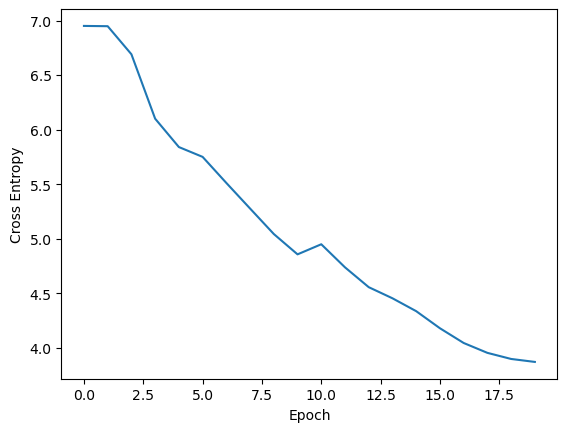

In [57]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.show()

## Inference

We will save the final model to `rnn_final.net`

In [59]:
gru = GRUTextGen(tokenizer=tokenizer,
                   embedding_dim=embedding_dim, 
                   hidden_dim=hidden_dim, 
                   num_layers=num_layers, 
                   dropout=dropout)
gru.to(DEVICE)
with open(f'rnn_final.net', 'rb') as f:
  checkpoint = torch.load(f)

gru.load_state_dict(checkpoint)


<All keys matched successfully>

In [60]:
gru.predict(input_text="To be or not to be",
            max_tokens=100)

'to be or not to be obedient sebastian so please you sir i am no prospero but to be endured prospero i have done so much more long of his love to be ta en from me prospero that i have been to have her in which will not have it wiselier no nor no my good lord prospero i have prospero that i have done mine own is my consent and mine my slave my spirit is more than my fancy miranda my ass miranda yes lucentio thou canst not choose prospero miranda miranda sir prospero sir prospero sir what cerns you of my master'

Conclusion: despite limitations on dataset and training resource, the model generates nearly grammatical correct sample.